In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error, mean_absolute_error

In [3]:
df = pd.read_excel('DATA/prepared/prepared_hard.xlsx')

In [5]:
ls = [
    'Скорость прохождения трубы через спрейер, м/с',
    't˚ C трубы после спреера'
]

In [24]:
df['t˚ C трубы после спреера'].dropna().sort_values()

17909      0.000000
17912      0.000000
17911      0.000000
17908      0.000000
17910      0.000000
3060       0.130000
16781     28.333333
218       29.000000
219       29.000000
2740      29.461538
2214      29.500000
15039     30.000000
16160     30.000000
15041     30.000000
15074     30.000000
16728     30.000000
15038     30.000000
2737      30.000000
2684      30.000000
3704      30.000000
2215      30.000000
15075     30.000000
15037     30.000000
15040     30.000000
15036     30.000000
1772      30.000000
1207      30.000000
2894      30.000000
16792     30.000000
2886      30.000000
            ...    
6799     195.000000
545      250.000000
21008    260.000000
22637    350.000000
22638    350.000000
22636    350.000000
22635    350.000000
243      350.000000
20165    480.000000
22692    480.000000
16966    480.000000
20164    480.000000
22849    480.000000
20393    480.000000
22789    480.000000
17083    480.000000
22640    480.000000
1600     480.000000
22639    480.000000


In [15]:
tr_df = df[ls].copy()
tr_df.dropna(inplace=True)

In [16]:
np.corrcoef(tr_df['Скорость прохождения трубы через спрейер, м/с'], tr_df['t˚ C трубы после спреера'])

array([[1.        , 0.21328368],
       [0.21328368, 1.        ]])

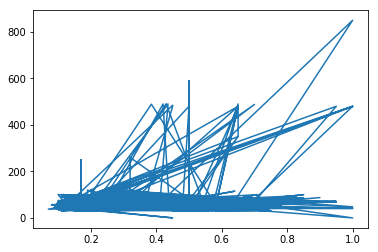

In [18]:
plt.plot(tr_df['Скорость прохождения трубы через спрейер, м/с'], tr_df['t˚ C трубы после спреера'])
plt.show()